In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from typing import Tuple

import tensorflow as tf

from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler

import shap

2025-03-28 12:11:26.560910: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
np.set_printoptions(suppress=True)

## Data Loading

In [21]:
data = pd.read_csv("data/marp_data.csv", sep=";")
data = data[data["attention_check"] == 1]

In [7]:
predictors = ['rel_1', 'rel_2', 'rel_3', 'rel_4', 'rel_5', 'rel_6', 'rel_7', 'rel_8', 'rel_9', \
              'cnorm_1', 'cnorm_2', 'age', 'gender', 'ethnicity', 'education', 'gdp', 'gdp_scaled', \
              'sample_type', 'compensation', 'denomination', 'country', 'ses']
regression_targets = ['wb_overall_mean']
# regression_targets = ['wb_overall_mean']


def justify_X(X: 'pd.DataFrame', use_wb_soc_3: bool = False) -> 'pd.DataFrame': 
    # List needed dummies
    dummies_needed = ['rel_3', 'rel_4', 'gender', 'ethnicity', 'sample_type', 'compensation', 'denomination', 'country']
    scaling_needed = list(filter(lambda x: x not in dummies_needed, predictors))
    if use_wb_soc_3: 
        dummies_needed.append('answered_sex_life_question')

    # Grab predictor columns
    X_new = X[predictors]

    # Get whether they answered the sexlife question as its own variable
    if use_wb_soc_3: 
        X_new.loc[:, 'answered_sex_life_question'] = X['wb_soc_3'].isna()

    # Do imputations
    for column in X_new.columns: 
        if sum(X_new[column].isna()) == 0:
            continue
        if column not in dummies_needed: 
            X_new[column] = X_new[column].fillna(X_new[column].mean())

    # Do scaling
    scaler = StandardScaler()
    X_new[scaling_needed] = scaler.fit_transform(X_new[scaling_needed])
    
    # Get dummies
    dummies_with_na = list(filter(lambda x: sum(X_new[x].isna()) > 0, dummies_needed))
    dummies_without_na = list(filter(lambda x: x not in dummies_with_na, dummies_needed))
    X_new = pd.get_dummies(X_new, columns=dummies_with_na, dummy_na=True)
    return(pd.get_dummies(X_new, columns=dummies_without_na, dummy_na=False))


def justify_data(data: 'pd.DataFrame', use_wb_soc_3: bool = True, test_size: float = .2, seed: int = 42, random: bool = False) -> \
            Tuple['pd.DataFrame', 'pd.DataFrame']: 
    
    X = justify_X(data, use_wb_soc_3=use_wb_soc_3)
    y = data[regression_targets]
    
    if random: 
        return X, y
    return X, y

In [8]:
X, y = justify_data(data, use_wb_soc_3=False)

/var/folders/pw/fd4pnrrx6wd9wgr2zmtjqqb80000gn/T/ipykernel_21005/3076125625.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_new[column] = X_new[column].fillna(X_new[column].mean())
/var/folders/pw/fd4pnrrx6wd9wgr2zmtjqqb80000gn/T/ipykernel_21005/3076125625.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_new[scaling_needed] = scaler.fit_transform(X_new[scaling_needed])


## Neural Network

In [10]:
# Model definition and fit
nn_model = tf.keras.Sequential([
    tf.keras.Input(shape=(X.shape[1],)),
    tf.keras.layers.Dense(124, activation="relu"),
    tf.keras.layers.Dense(124, activation="relu"),
    tf.keras.layers.Dense(124, activation="relu"),
    tf.keras.layers.Dense(1, activation="linear")
])

# Spe fy the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Compiling the model
nn_model.compile(optimizer=optimizer, loss="mean_squared_error", metrics=["root_mean_squared_error"])

# Training the model
history = nn_model.fit(x=X, y=y, batch_size=32, epochs=150, validation_split=0.1)

Epoch 1/150
259/259 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5.7693 - root_mean_squared_error: 2.3226 - val_loss: 0.4285 - val_root_mean_squared_error: 0.6546
Epoch 2/150
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3824 - root_mean_squared_error: 0.6184 - val_loss: 0.3675 - val_root_mean_squared_error: 0.6063
Epoch 3/150
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3449 - root_mean_squared_error: 0.5870 - val_loss: 0.3400 - val_root_mean_squared_error: 0.5831
Epoch 4/150
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3178 - root_mean_squared_error: 0.5636 - val_loss: 0.3208 - val_root_mean_squared_error: 0.5664
Epoch 5/150
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2940 - root_mean_squared_error: 0.5422 - val_loss: 0.3113 - val_root_mean_squared_error: 0.5579
Epoch 6/150
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2983 - root_mean_squared_error: 0.5460 - val_loss: 0.3045 - val_root_mean_squared_error: 0.5518
Epoch 7/150
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 2m

# Feature Importance

## Shapley Value Calculations

In [11]:
# Get sample of data for explainer
sampled_data = X.sample(n=1100).values.astype(float)
background_data = sampled_data[:100]
shap_data = sampled_data[100:]

# Build the explainer
nn_explainer = shap.DeepExplainer(nn_model, background_data)

# Get the shapley vaues
shap_values = nn_explainer.shap_values(shap_data)[:,:,0]

/Users/chris/anaconda3/envs/behavioral-data-science/lib/python3.11/site-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
/Users/chris/anaconda3/envs/behavioral-data-science/lib/python3.11/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(100, 94))']
  warnings.warn(msg)
/Users/chris/anaconda3/envs/behavioral-data-science/lib/python3.11/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: 

## Shapley Value Reporting

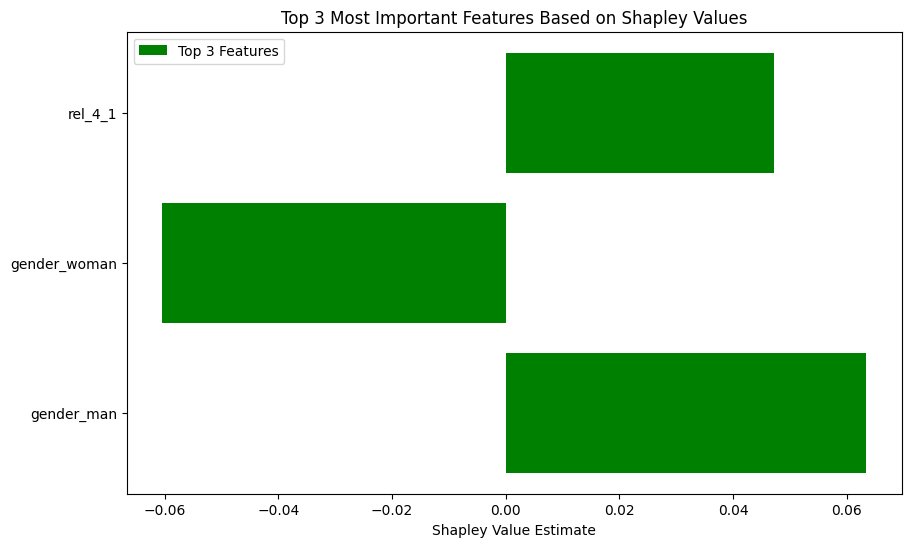

In [17]:
mean_shap_values = shap_values.mean(axis=0)
abs_mean_shap_values = np.abs(mean_shap_values)

# Get the feature names
features = X.columns

# Sort the features by the mean absolute Shapley values
sorted_idx = np.argsort(abs_mean_shap_values)[::-1]
top_3 = sorted_idx[:3]

# Prepare data for the plot
top_3_values = mean_shap_values[top_3]
top_3_features = [features[i] for i in top_3]

# Plot the 10 most and 10 least important features
plt.figure(figsize=(10, 6))

# Plot top 10 important features
plt.barh(top_3_features, top_3_values, color='green', label='Top 3 Features')

# Add labels and title
plt.xlabel("Shapley Value Estimate")
plt.title("Top 3 Most Important Features Based on Shapley Values")
plt.legend()

# Show the plot
plt.show()

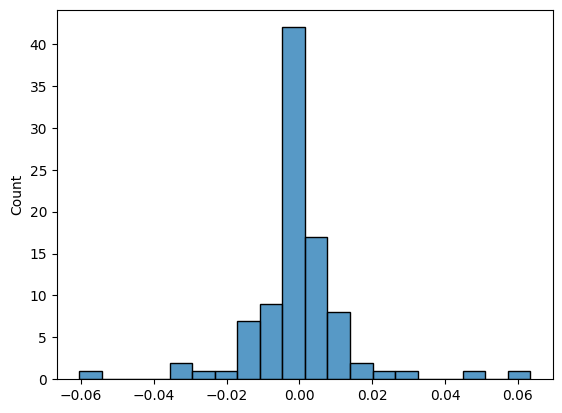

In [15]:
histplot = sns.histplot(mean_shap_values, bins=20)


In [20]:
print(top_3_values)

[ 0.06347577 -0.06046895  0.04718239]
